In [2]:
import os
import pandas as pd
from dotenv import load_dotenv
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

pd.set_option('chained_assignment',None)
pd.set_option('display.max_columns', None)  
# 1. Обзор данных  
load_dotenv()
access_key = os.getenv("S3_ACCESS_KEY")
secret_key = os.getenv("S3_SECRET_KEY")

storage_options = {
    "key": access_key,
    "secret": secret_key,
    "client_kwargs": {
        "endpoint_url": "https://storage.yandexcloud.kz"
    }
}

def read_parquet_from_s3(s3_path, storage_options):
    try:
        return pd.read_parquet(s3_path, storage_options=storage_options)
    except Exception as e:
        print(f"Error reading {s3_path}: {e}")
        return None

numeric_cols = [
    'TOTALAMOUNT',
    'SUM_CREDIT_KZT',
    'DM5DPD1GCVPSUM',
    'DM5DPD1SALARYSUM',
    'DM5EXPSUM',
    'DM5INCSUM',
    'DM5INC',
    'DM5EXP',
    'DM7INC',
    'DM7EXP',
    'DM6SCOREN6PD',
    'DM6SCOREN6',
    'FINALKDN',
    'CREDITTERM_RBL0',
    'CLI_AGE',
    'DEPENDANT_COUNT',
    'IS_SERVWS_MNLI'
]
categorical_cols = [
    'PURPOSE_LOAN',
    'OPV_REASON',
    'KANAL_PRODAZH',
    'APPLICATION_ISA0AUTO',
    'GENDER',
    'BKI',
    'VKI',
    'MARITALSTATUS'
]
label_cols = [
    'REGCOUNTY',
    'BRANCH'
]
fin_num_cols = [
    'APPLICATIONID',
    'CREATE_DATETIME', 
    'TOTALAMOUNT',
    'SUM_CREDIT_KZT',
    'DM5DPD1GCVPSUM',
    'DM5DPD1SALARYSUM',
    'DM5EXPSUM',
    'DM5INCSUM',
    'DM5INC',
    'DM5EXP',
    'DM7INC',
    'DM7EXP',
    'DM6SCOREN6PD',
    'DM6SCOREN6',
    'FINALKDN',
    'CREDITTERM_RBL0',
    'CLI_AGE',
    'DEPENDANT_COUNT',
    'IS_SERVWS_MNLI',
    'target'
]
def clean_numeric(col):
    return pd.to_numeric(
        col.astype(str)
        .str.replace(" ", "", regex=False)
        .str.replace(",", ".", regex=False),
        errors="coerce"
    )

def prepare_data(x):
    s3_app_path = f"s3://data-for-case-3/tabledata/{x}_data/{x}_app_data.parquet"
    if x =='valid': 
        s3_target_path = f"s3://data-for-case-3/tabledata/{x}_data/{x}_target_df.parquet"
    else:    
        s3_target_path = f"s3://data-for-case-3/tabledata/{x}_data/{x}_target_data.parquet"
    df_app = read_parquet_from_s3(s3_app_path, storage_options)
    df_target = read_parquet_from_s3(s3_target_path, storage_options)

    if x =='valid': 
        df_merged = df_app.merge(df_target[['APPLICATIONID']], on='APPLICATIONID', how='inner')
    else:   
        df_merged = df_app.merge(df_target[['APPLICATIONID', 'target']], on='APPLICATIONID', how='inner')
    df_merged.columns = df_merged.columns.str.strip()
    df_merged.columns = df_merged.columns.str.replace(" ", "")
    df_merged['IS_SERVWS_MNLI'] = df_merged['MNG_NAME_LOGIN_INIT'].apply(lambda x: 1 if x == 'servws' else 0 )
    df_merged.drop(columns=['CREATE_DATE','DATA_ISSUE', 'VINTAGE','SPF','REGREGION','REGTOWN','COMPANY_NAME','BIRTHCOUNTRY','PRODUCT_GROUP','MNG_NAME_LOGIN_INIT','MNG_NAME_INIT',],inplace=True) 

    for col in numeric_cols:
        if col in df_merged.columns:
            df_merged[col] = clean_numeric(df_merged[col])

    df_categorical_ohe = pd.get_dummies(df_merged[categorical_cols], prefix=categorical_cols).astype(int)
    # Копируем DataFrame для безопасной работы
    df_encoded = df_merged[label_cols]

    # Применяем LabelEncoder ко всем колонкам из списка
    for col in label_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))  # приводим к str на случай пропусков или NaN

    if x =='valid': 
        fin_num_cols.remove('target')
        df_numeric = df_merged[fin_num_cols]
    else:   
        df_numeric = df_merged[fin_num_cols]
    
    # Убедимся, что у всех датафреймов одинаковый порядок индексов
    df_encoded = df_encoded.reset_index(drop=True)
    df_categorical_ohe = df_categorical_ohe.reset_index(drop=True)
    df_numeric = df_numeric.reset_index(drop=True)

    # Объединяем все фичи
    df_model = pd.concat([df_numeric, df_categorical_ohe, df_encoded[label_cols]], axis=1)
    df_model['data'] = x
    return df_model

In [7]:
train = prepare_data('train')
test = prepare_data('test')
valid = prepare_data('valid')

In [8]:
test.shape, train.shape, valid.shape

((5528, 46), (18386, 46), (6379, 45))

In [9]:
final = pd.concat([train,test,valid])
final = final.reset_index().drop(columns='index')

In [11]:
final.to_csv('table_features_final.csv',index=False)

In [ ]:
import pandas as pd
import joblib
import argparse
import os
from dotenv import load_dotenv
from sklearn.preprocessing import LabelEncoder
from functools import reduce

# --- Глобальные переменные (колонки)
numeric_cols = [
    'TOTALAMOUNT', 'SUM_CREDIT_KZT', 'DM5DPD1GCVPSUM', 'DM5DPD1SALARYSUM', 'DM5EXPSUM',
    'DM5INCSUM', 'DM5INC', 'DM5EXP', 'DM7INC', 'DM7EXP', 'DM6SCOREN6PD', 'DM6SCOREN6',
    'FINALKDN', 'CREDITTERM_RBL0', 'CLI_AGE', 'DEPENDANT_COUNT', 'IS_SERVWS_MNLI'
]
categorical_cols = [
    'PURPOSE_LOAN', 'OPV_REASON', 'KANAL_PRODAZH', 'APPLICATION_ISA0AUTO', 'GENDER', 'BKI', 'VKI', 'MARITALSTATUS'
]
label_cols = ['REGCOUNTY', 'BRANCH']
fin_num_cols = [
    'APPLICATIONID', 'CREATE_DATETIME', 'TOTALAMOUNT', 'SUM_CREDIT_KZT',
    'DM5DPD1GCVPSUM', 'DM5DPD1SALARYSUM', 'DM5EXPSUM', 'DM5INCSUM', 'DM5INC',
    'DM5EXP', 'DM7INC', 'DM7EXP', 'DM6SCOREN6PD', 'DM6SCOREN6', 'FINALKDN',
    'CREDITTERM_RBL0', 'CLI_AGE', 'DEPENDANT_COUNT', 'IS_SERVWS_MNLI'
]

# --- Утилиты
def clean_numeric(col):
    return pd.to_numeric(
        col.astype(str)
        .str.replace(" ", "", regex=False)
        .str.replace(",", ".", regex=False),
        errors="coerce"
    )

def read_parquet_from_s3(s3_path, storage_options):
    try:
        return pd.read_parquet(s3_path, storage_options=storage_options)
    except Exception as e:
        print(f"❌ Error reading {s3_path}: {e}")
        return None

def prepare_data(storage_options):
    s3_app_path = f"s3://data-for-case-3/tabledata/valid_data/valid_app_data.parquet"
    s3_target_path = f"s3://data-for-case-3/tabledata/valid_data/valid_target_df.parquet"
    df_app = read_parquet_from_s3(s3_app_path, storage_options)
    df_target = read_parquet_from_s3(s3_target_path, storage_options)

    df_merged = df_app.merge(df_target[['APPLICATIONID']], on='APPLICATIONID', how='inner')
    df_merged.columns = df_merged.columns.str.strip().str.replace(" ", "")

    df_merged['IS_SERVWS_MNLI'] = df_merged['MNG_NAME_LOGIN_INIT'].apply(lambda x: 1 if x == 'servws' else 0)
    df_merged.drop(columns=[
        'CREATE_DATE','DATA_ISSUE','VINTAGE','SPF','REGREGION','REGTOWN',
        'COMPANY_NAME','BIRTHCOUNTRY','PRODUCT_GROUP','MNG_NAME_LOGIN_INIT','MNG_NAME_INIT'
    ], inplace=True)

    for col in numeric_cols:
        if col in df_merged.columns:
            df_merged[col] = clean_numeric(df_merged[col])

    df_categorical_ohe = pd.get_dummies(df_merged[categorical_cols], prefix=categorical_cols).astype(int)

    df_encoded = df_merged[label_cols].copy()
    for col in label_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

    df_numeric = df_merged[fin_num_cols]

    df_encoded = df_encoded.reset_index(drop=True)
    df_categorical_ohe = df_categorical_ohe.reset_index(drop=True)
    df_numeric = df_numeric.reset_index(drop=True)

    df_model = pd.concat([df_numeric, df_categorical_ohe, df_encoded[label_cols]], axis=1)
    
    return df_model

def run_inference(model, df_features, df_ids):
    proba = model.predict_proba(df_features.drop(columns=['APPLICATIONID', 'CREATE_DATETIME', 'data']))[:, 1]
    pred = (proba > 0.5).astype(int)

    result = pd.DataFrame({
        'id': df_ids,
        'prediction': pred,
        'prediction_probability': proba
    })
    return result

# --- Главная функция
def main():
    load_dotenv()
    storage_options = {
        "key": os.getenv("S3_ACCESS_KEY"),
        "secret": os.getenv("S3_SECRET_KEY"),
        "client_kwargs": {
            "endpoint_url": "https://storage.yandexcloud.kz"
        }
    }

    parser = argparse.ArgumentParser()
    parser.add_argument('--model', type=str, default='model_antifraud.pkl')
    parser.add_argument('--output', type=str, default='result.csv')
    args = parser.parse_args()

    print("📥 Загружаем модель...")
    model = joblib.load(args.model)

    print(f"🧼 Предобработка данных: {args.data_tag}")
    df_features, df_ids = prepare_data(args.data_tag, storage_options)

    print("🤖 Запуск инференса...")
    result_df = run_inference(model, df_features, df_ids)

    print("💾 Сохраняем результат...")
    result_df.to_csv(args.output, index=False)
    print(f"✅ Saved to {args.output}")


In [41]:

s3_ampl= "s3://data-for-case-3/tabledata/valid_data/valid_amplitude_chunk_00.parquet"

storage_options = {
    "key": "YCB2BAvtu7_kXfgsmzA_0xv4i",
    "secret": "YCNnsH6n4uHb6_OQ5fpkhN8F4ZhgNbZLwJqsccoV",
    "client_kwargs": {
        "endpoint_url": "https://storage.yandexcloud.kz"
    }
}

df_all = pd.read_parquet(s3_ampl, storage_options=storage_options)
s3_path = "s3://data-for-case-3/tabledata/valid_data/valid_app_data.parquet"


access_key = "YCB2BAvtu7_kXfgsmzA_0xv4i"
secret_key = "YCNnsH6n4uHb6_OQ5fpkhN8F4ZhgNbZLwJqsccoV"


df_app = pd.read_parquet(
    s3_path,
    storage_options={
        "key": access_key,
        "secret": secret_key,
        "client_kwargs": {
            "endpoint_url": "https://storage.yandexcloud.kz"
        }
    }
)
df_app.head()
s3_target_val = "s3://data-for-case-3/tabledata/valid_data/valid_target_df.parquet"

df_target = pd.read_parquet(
    s3_target_val,
    storage_options={
        "key": access_key,
        "secret": secret_key,
        "client_kwargs": {
            "endpoint_url": "https://storage.yandexcloud.kz"
        }
    }
)

df_target.head()
df_target[df_target['APPLICATIONID'].duplicated()]
df_target['target']= None

df_all.drop_duplicates(subset = ['applicationid','event_id'], keep = 'first',inplace=True)
df_all["client_event_time"] = pd.to_datetime(df_all["client_event_time"], utc=True)
df_all["client_event_time"] = df_all["client_event_time"].dt.tz_localize(None)
df_final_app = df_app[['APPLICATIONID', 'CREATE_DATETIME']].merge(df_target[['APPLICATIONID','target']], on = ['APPLICATIONID'], how = 'left')
df_final = df_final_app.merge(df_all, left_on="APPLICATIONID", right_on="applicationid", how = 'left')
df_final["client_event_time"] = pd.to_datetime(df_final["client_event_time"], utc=True)
df_final["client_event_time"] = df_final["client_event_time"].dt.tz_localize(None)
df_final["CREATE_DATETIME"] = pd.to_datetime(df_final["CREATE_DATETIME"], format="%d.%m.%Y %H:%M", errors="coerce")
df_final["user_creation_time"] = pd.to_datetime(df_final["user_creation_time"], errors="coerce")
df_final["days_after_registration"] = (
    df_final["CREATE_DATETIME"] - df_final["user_creation_time"]
).dt.days

def extract_event_features(df, window_days):
    df_window = df[
        (df["client_event_time"] <= df["CREATE_DATETIME"]) &
        (df["client_event_time"] > df["CREATE_DATETIME"] - pd.to_timedelta(window_days, unit="d"))
    ].copy()


    aggregated = df_window.groupby("APPLICATIONID").agg(
        **{
            f"country_kz_ratio_{window_days}d": ("country", lambda x: (x == "Kazakhstan").mean()),
            f"n_unique_device_id_{window_days}d": ("device_id", pd.Series.nunique),
            f"n_unique_event_type_{window_days}d": ("event_type", pd.Series.nunique),
            f"n_unique_ip_{window_days}d": ("ip_address", pd.Series.nunique),
            f"n_event_id_{window_days}d": ("event_id", "count") 
         
        }
    ).reset_index()

    return aggregated

from functools import reduce
features_list = [extract_event_features(df_final, days) for days in [1, 2, 3, 30]]

df_event_features = reduce(
    lambda left, right: pd.merge(left, right, on="APPLICATIONID", how="outer"),
    features_list
)

df_model_input = (
    df_final[["APPLICATIONID", "CREATE_DATETIME", "target"]]
    .drop_duplicates()
    .merge(df_event_features, on="APPLICATIONID", how="left")
)
def extract_os_features_30d(df):
    df_window = df[
        (df["client_event_time"] <= df["CREATE_DATETIME"]) &
        (df["client_event_time"] > df["CREATE_DATETIME"] - pd.Timedelta(days=30))
    ].copy()

   
    df_last = (
        df_window.sort_values(["APPLICATIONID", "client_event_time"], ascending=[True, False])
        .groupby("APPLICATIONID")
        .first()
        .reset_index()[["APPLICATIONID", "os_name"]]
        .rename(columns={"os_name": "last_os_name_30d"})
    )

  
    df_mode = (
        df_window.groupby("APPLICATIONID")["os_name"]
        .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
        .reset_index()
        .rename(columns={"os_name": "most_common_os_name_30d"})
    )

    df_os = df_last.merge(df_mode, on="APPLICATIONID", how="left")

    return df_os
df_os_30d = extract_os_features_30d(df_final)

df_model_input = (
    df_model_input.drop_duplicates()
    .merge(df_os_30d, on="APPLICATIONID", how="left")
)

In [45]:
df_model_input[['country_kz_ratio_1d', 'n_unique_device_id_1d',
       'n_unique_event_type_1d', 'n_unique_ip_1d', 'n_event_id_1d',
       'country_kz_ratio_2d', 'n_unique_device_id_2d',
       'n_unique_event_type_2d', 'n_unique_ip_2d', 'n_event_id_2d',
       'country_kz_ratio_3d', 'n_unique_device_id_3d',
       'n_unique_event_type_3d', 'n_unique_ip_3d', 'n_event_id_3d',
       'country_kz_ratio_30d', 'n_unique_device_id_30d',
       'n_unique_event_type_30d', 'n_unique_ip_30d', 'n_event_id_30d']]

,country_kz_ratio_1d,n_unique_device_id_1d,n_unique_event_type_1d,n_unique_ip_1d,n_event_id_1d,country_kz_ratio_2d,n_unique_device_id_2d,n_unique_event_type_2d,n_unique_ip_2d,n_event_id_2d,country_kz_ratio_3d,n_unique_device_id_3d,n_unique_event_type_3d,n_unique_ip_3d,n_event_id_3d,country_kz_ratio_30d,n_unique_device_id_30d,n_unique_event_type_30d,n_unique_ip_30d,n_event_id_30d
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,32.0,3.0,75.0,1.0,1.0,32.0,3.0,75.0,1.0,1.0,32.0,4.0,77.0,1.0,1.0,46.0,10.0,198.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6376,1.0,1.0,46.0,3.0,108.0,1.0,1.0,46.0,4.0,116.0,1.0,1.0,46.0,5.0,129.0,1.0,1.0,47.0,7.0,188.0
6377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
import pandas as pd
from functools import reduce
from sklearn.preprocessing import LabelEncoder
import joblib


# --- Константы
S3_AMPL = "s3://data-for-case-3/tabledata/valid_data/valid_amplitude_chunk_00.parquet"
S3_APP = "s3://data-for-case-3/tabledata/valid_data/valid_app_data.parquet"
S3_TARGET = "s3://data-for-case-3/tabledata/valid_data/valid_target_df.parquet"

STORAGE_OPTIONS = {
    "key": "YCB2BAvtu7_kXfgsmzA_0xv4i",
    "secret": "YCNnsH6n4uHb6_OQ5fpkhN8F4ZhgNbZLwJqsccoV",
    "client_kwargs": {"endpoint_url": "https://storage.yandexcloud.kz"}
}

numeric_cols = [
    'TOTALAMOUNT', 'SUM_CREDIT_KZT', 'DM5DPD1GCVPSUM', 'DM5DPD1SALARYSUM', 'DM5EXPSUM',
    'DM5INCSUM', 'DM5INC', 'DM5EXP', 'DM7INC', 'DM7EXP', 'DM6SCOREN6PD', 'DM6SCOREN6',
    'FINALKDN', 'CREDITTERM_RBL0', 'CLI_AGE', 'DEPENDANT_COUNT', 'IS_SERVWS_MNLI'
]
categorical_cols = [
    'PURPOSE_LOAN', 'OPV_REASON', 'KANAL_PRODAZH', 'APPLICATION_ISA0AUTO',
    'GENDER', 'BKI', 'VKI', 'MARITALSTATUS'
]
label_cols = ['REGCOUNTY', 'BRANCH']
fin_num_cols = [
    'APPLICATIONID', 'CREATE_DATETIME', 'TOTALAMOUNT', 'SUM_CREDIT_KZT',
    'DM5DPD1GCVPSUM', 'DM5DPD1SALARYSUM', 'DM5EXPSUM', 'DM5INCSUM', 'DM5INC',
    'DM5EXP', 'DM7INC', 'DM7EXP', 'DM6SCOREN6PD', 'DM6SCOREN6', 'FINALKDN',
    'CREDITTERM_RBL0', 'CLI_AGE', 'DEPENDANT_COUNT', 'IS_SERVWS_MNLI'
]
important_features = ['TOTALAMOUNT',
 'DM5DPD1GCVPSUM',
 'DM5EXPSUM',
 'DM5INCSUM',
 'DM5INC',
 'DM5EXP',
 'DM7INC',
 'DM7EXP',
 'DM6SCOREN6PD',
 'DM6SCOREN6',
 'FINALKDN',
 'CREDITTERM_RBL0',
 'CLI_AGE',
 'DEPENDANT_COUNT',
 'PURPOSE_LOAN_На потребительские цели',
 'KANAL_PRODAZH_B-Bank',
 'KANAL_PRODAZH_QR',
 'GENDER_Женский',
 'BKI_Плохая',
 'VKI_Хорошая',
 'MARITALSTATUS_Женат/Замужем',
 'country_kz_ratio_1d',
 'n_unique_device_id_1d',
 'n_unique_event_type_1d',
 'n_unique_ip_1d',
 'n_event_id_1d',
 'n_event_id_2d',
 'country_kz_ratio_3d',
 'n_event_id_3d',
 'country_kz_ratio_30d',
 'n_unique_event_type_30d',
 'n_unique_ip_30d',
 'n_event_id_30d']

def read_parquet_from_s3(s3_path, storage_options):
    try:
        return pd.read_parquet(s3_path, storage_options=storage_options)
    except Exception as e:
        print(f"Error reading {s3_path}: {e}")
        return None

def clean_numeric(col):
    return pd.to_numeric(
        col.astype(str)
        .str.replace(" ", "", regex=False)
        .str.replace(",", ".", regex=False),
        errors="coerce"
    )

def prepare_table_data(df_app, df_target):
    df_merged = df_app.merge(df_target[['APPLICATIONID']], on='APPLICATIONID', how='inner')
    df_merged.columns = df_merged.columns.str.strip().str.replace(" ", "")
    df_merged['IS_SERVWS_MNLI'] = (df_merged['MNG_NAME_LOGIN_INIT'] == 'servws').astype(int)
    drop_cols = [
        'CREATE_DATE','DATA_ISSUE', 'VINTAGE','SPF','REGREGION','REGTOWN',
        'COMPANY_NAME','BIRTHCOUNTRY','PRODUCT_GROUP','MNG_NAME_LOGIN_INIT','MNG_NAME_INIT'
    ]
    df_merged = df_merged.drop(columns=[col for col in drop_cols if col in df_merged.columns], errors='ignore')
    for col in numeric_cols:
        if col in df_merged.columns:
            df_merged[col] = clean_numeric(df_merged[col])
    df_categorical_ohe = pd.get_dummies(df_merged[categorical_cols], prefix=categorical_cols, dtype=int)
    df_encoded = df_merged[label_cols].apply(lambda col: LabelEncoder().fit_transform(col.astype(str)))
    df_numeric = df_merged[[col for col in fin_num_cols if col in df_merged.columns]]
    # Сброс индексов для корректного объединения
    df_numeric = df_numeric.reset_index(drop=True)
    df_categorical_ohe = df_categorical_ohe.reset_index(drop=True)
    df_encoded = df_encoded.reset_index(drop=True)
    return pd.concat([df_numeric, df_categorical_ohe, df_encoded], axis=1)

def extract_event_features(df, window_days):
    mask = (
        (df["client_event_time"] <= df["CREATE_DATETIME"]) &
        (df["client_event_time"] > df["CREATE_DATETIME"] - pd.Timedelta(days=window_days))
    )
    df_window = df[mask]
    return (
        df_window.groupby("APPLICATIONID").agg(
            **{
                f"country_kz_ratio_{window_days}d": ("country", lambda x: (x == "Kazakhstan").mean()),
                f"n_unique_device_id_{window_days}d": ("device_id", pd.Series.nunique),
                f"n_unique_event_type_{window_days}d": ("event_type", pd.Series.nunique),
                f"n_unique_ip_{window_days}d": ("ip_address", pd.Series.nunique),
                f"n_event_id_{window_days}d": ("event_id", "count")
            }
        ).reset_index()
    )

def extract_os_features_30d(df):
    mask = (
        (df["client_event_time"] <= df["CREATE_DATETIME"]) &
        (df["client_event_time"] > df["CREATE_DATETIME"] - pd.Timedelta(days=30))
    )
    df_window = df[mask]
    df_last = (
        df_window.sort_values(["APPLICATIONID", "client_event_time"], ascending=[True, False])
        .groupby("APPLICATIONID", as_index=False)
        .first()[["APPLICATIONID", "os_name"]]
        .rename(columns={"os_name": "last_os_name_30d"})
    )
    df_mode = (
        df_window.groupby("APPLICATIONID")['os_name']
        .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
        .reset_index()
        .rename(columns={"os_name": "most_common_os_name_30d"})
    )
    return df_last.merge(df_mode, on="APPLICATIONID", how="left")

# --- Загрузка данных
df_app = read_parquet_from_s3(S3_APP, STORAGE_OPTIONS)
df_target = read_parquet_from_s3(S3_TARGET, STORAGE_OPTIONS)
df_table_data = prepare_table_data(df_app, df_target)

# --- Загрузка и обработка амплитудных данных
df_all = read_parquet_from_s3(S3_AMPL, STORAGE_OPTIONS)
df_target['target'] = None  # если нужно, иначе уберите
df_all = df_all.drop_duplicates(subset=['applicationid', 'event_id'], keep='first')
df_all['client_event_time'] = pd.to_datetime(df_all['client_event_time'], utc=True).dt.tz_localize(None)
df_app['CREATE_DATETIME'] = pd.to_datetime(df_app['CREATE_DATETIME'], format="%d.%m.%Y %H:%M", errors="coerce")
df_final = (
    df_app[['APPLICATIONID', 'CREATE_DATETIME']]
    .merge(df_target[['APPLICATIONID', 'target']], on='APPLICATIONID', how='left')
    .merge(df_all, left_on='APPLICATIONID', right_on='applicationid', how='left')
)
df_final['user_creation_time'] = pd.to_datetime(df_final['user_creation_time'], errors='coerce')
df_final['days_after_registration'] = (df_final['CREATE_DATETIME'] - df_final['user_creation_time']).dt.days

# --- Извлечение признаков
features_list = [extract_event_features(df_final, days) for days in [1, 2, 3, 30]]
df_event_features = reduce(lambda left, right: pd.merge(left, right, on="APPLICATIONID", how="outer"), features_list)
df_os_30d = extract_os_features_30d(df_final)
# --- Финальный датасет
df_ampl_data = (
    df_final[["APPLICATIONID", "CREATE_DATETIME", "target"]]
    .drop_duplicates()
    .merge(df_event_features, on="APPLICATIONID", how="left")
    .merge(df_os_30d, on="APPLICATIONID", how="left")
)
df_model_input = pd.merge(df_ampl_data, df_table_data, on='APPLICATIONID', how='inner')
df_model_input['new_os'] = df_model_input.apply(lambda x: 1 if x['most_common_os_name_30d'] == x['last_os_name_30d'] else 0, axis=1)
le = LabelEncoder()
df_model_input['last_os_name_30d_encoded'] = le.fit_transform(df_model_input['last_os_name_30d'])
df_model_input['most_common_os_name_30d_encoded'] = le.fit_transform(df_model_input['most_common_os_name_30d'])
X_val_proba = df_model_input[important_features]
# Загрузка модели
final_model = joblib.load('model_antifraud.pkl')
y_val_proba = final_model.predict_proba(X_val_proba)[:, 1]
y_val_pred = (y_val_proba >= 0.5).astype(int)
df_result = df_model_input.loc[X_val_proba.index, ['APPLICATIONID']].copy()
df_result['isFrod'] = y_val_pred
df_result['fraud_probability'] = y_val_proba
assert len(df_model_input) == len(y_val_proba)
print(df_result['predicted_label'].value_counts())

df_result.to_csv('result_1.csv',index=False)
print('Table data prediction results saved to csv: result_1.csv')

In [111]:
df_result = df_model_input.loc[X_val_proba.index, ['APPLICATIONID']].copy()
df_result.rename(columns={'APPLICATIONID':'id'},inplace=True)
df_result['isFrod'] = y_val_pred
df_result['probability'] = y_val_proba
assert len(df_model_input) == len(y_val_proba)
print(df_result['isFrod'].value_counts())

df_result.to_csv('result_1.csv',index=False)
print('Table data prediction results saved to csv: result_1.csv')

isFrod
0    6163
1     216
Name: count, dtype: int64
Table data prediction results saved to csv: result_1.csv


In [112]:
df_result

,id,isFrod,probability
0,Д\286\012220838,0,0.018587
1,Д\286\012249879,0,0.017282
2,Д\286\012273876,0,0.036207
3,Д\286\012288632,0,0.016456
4,Д\286\011592446,0,0.003669
...,...,...,...
6374,Д\286\012275441,0,0.145909
6375,Д\286\012141252,0,0.009709
6376,Д\286\012161697,0,0.018761
6377,Д\286\012248249,0,0.009688


In [104]:
df_result['predicted_label'].value_counts()

predicted_label
0    6163
1     216
Name: count, dtype: int64

/tmp/ipykernel_14498/2538329130.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort = df_result.groupby('prob_bin').agg(


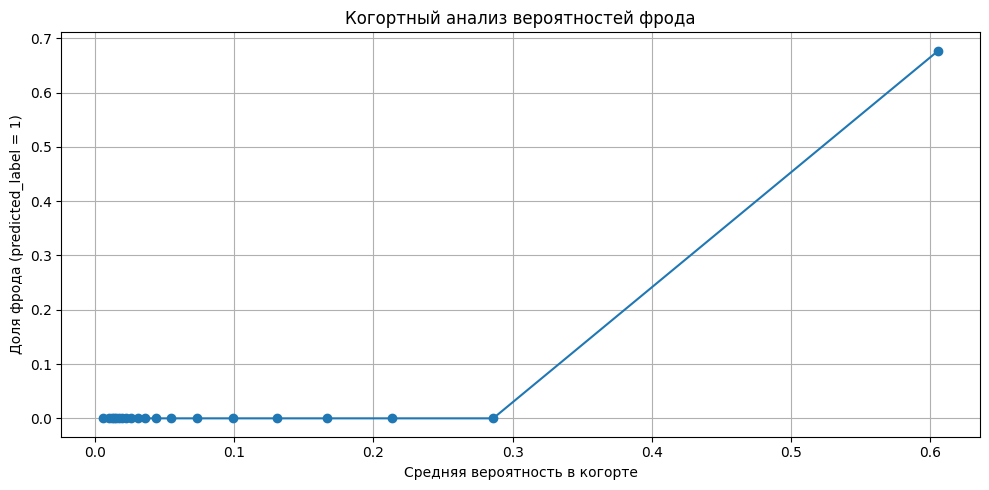

In [105]:
import pandas as pd
import matplotlib.pyplot as plt

# Предположим, у тебя уже есть df_result:
# с колонками: APPLICATIONID, predicted_label, fraud_probability

# Создаем когорты по квантилям вероятности
df_result['prob_bin'] = pd.qcut(df_result['fraud_probability'], q=20, duplicates='drop')

# Группируем по когорте
cohort = df_result.groupby('prob_bin').agg(
    total=('fraud_probability', 'count'),
    frauds=('predicted_label', 'sum'),
    avg_proba=('fraud_probability', 'mean')
).reset_index()

# Доля фрода в каждой когорте
cohort['fraud_rate'] = cohort['frauds'] / cohort['total']

# Сортируем по вероятности
cohort = cohort.sort_values('avg_proba')

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(cohort['avg_proba'], cohort['fraud_rate'], marker='o')
plt.title('Когортный анализ вероятностей фрода')
plt.xlabel('Средняя вероятность в когорте')
plt.ylabel('Доля фрода (predicted_label = 1)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Чтение двух файлов
df_main = pd.read_csv("result.csv")           # содержит: id, isFrod_main, prob_main

In [15]:
df_audio= pd.DataFrame()

In [16]:
df_audio.id = df_main.id.sample(40)

/tmp/ipykernel_23327/2695160334.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_audio.id = df_main.id.sample(40)


In [17]:
df_audio.shape

(0, 0)

In [11]:
df_audio[df_audio.id.isin(df_audio.id.sample(10).to_list())]

/tmp/ipykernel_23327/370824482.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_audio[df_audio.id.isin(df_audio.id.sample(10).to_list())]


""


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Чтение двух файлов
df_main = pd.read_csv("result.csv")           # содержит: id, isFrod_main, prob_main
df_audio = pd.read_csv("result_audio.csv")    # содержит: id, isFrod_audio, prob_audio

# Переименуем колонки для ясности
df_main = df_main.rename(columns={'isFrod': 'isFrod_main', 'probability': 'prob_main'})
df_audio = df_audio.rename(columns={'isFrod': 'isFrod_audio', 'probability': 'prob_audio'})

# Объединяем по ID
df_merged = df_main.merge(df_audio, on='id', how='left')

# --- Найдём веса по тем, у кого есть и основная и аудио вероятность
df_overlap = df_merged.dropna(subset=['prob_audio'])

# Обучаем линейную регрессию: prob_main и prob_audio → финальная оценка
X = df_overlap[['prob_main', 'prob_audio']]
y = df_overlap['isFrod_main']  # или можно использовать просто prob_main как proxy

model = LinearRegression()
model.fit(X, y)

w1, w2 = model.coef_
print(f"💡 Обученные веса: prob_main * {w1:.3f} + prob_audio * {w2:.3f}")

# --- Применяем на всём датасете
df_merged['final_prob'] = df_merged['prob_main'] * w1 + df_merged['prob_audio'].fillna(0) * w2

# Бинарное решение
df_merged['isFrod'] = (df_merged['final_prob'] >= 0.5).astype(int)

# Финальный файл
df_result = df_merged[['id', 'isFrod', 'final_prob']].rename(columns={'final_prob': 'probability'})
df_result.to_csv("result_blended.csv", index=False)

print("✅ Финальный файл сохранён: result_blended.csv")
